# Introduction

** Kaggle dataset on survival of Titanic passengers**

https://www.kaggle.com/c/titanic


* Description of variables: https://www.kaggle.com/c/titanic/data
* Used this notebook as starting point: https://www.kaggle.com/startupsci/titanic-data-science-solutions

**Resources**
 
***General***
* https://www.dataquest.io/blog/kaggle-tutorial
* https://elitedatascience.com/beginner-kaggle


* http://scikit-learn.org/stable/modules/cross_validation.html
* https://stats.stackexchange.com/questions/27730/choice-of-k-in-k-fold-cross-validation
* https://stats.stackexchange.com/questions/154830/10-fold-cross-validation-vs-leave-one-out-cross-validation
* http://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html

* https://github.com/Kaggle/kaggle-api

***Dataset-specific***
* https://rstudio-pubs-static.s3.amazonaws.com/210751_04c6a0cdc640468eb6471d408a839b63.html#gradient-boosting-machine
* https://www.kaggle.com/anaskad/step-by-step-solving-titanic-problem
* https://www.kaggle.com/arjoonn/ticket-fare-analysis
* https://rstudio-pubs-static.s3.amazonaws.com/210751_04c6a0cdc640468eb6471d408a839b63.html#gradient-boosting-machine

**To Do**
* Create variable representing groups of passengers travelling together (same surname or same ticket)

# Setup

## Imports

In [668]:
import pandas as pd
import numpy as np
import random as rnd
from tqdm import tqdm_notebook as tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from IPython.core.pylabtools import figsize

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier

In [669]:
plt.style.use('ggplot')
mpl.rc("savefig", dpi=100)
figTextSize = 14

## Load data

In [670]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')
combine = [train_df, test_df]

### Quick view

In [671]:
combine[0].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [672]:
combine[1].head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Preprocessing

## Initial Data Transformations

### Convert Fare to Fare per Passenger
Many passengers share the same value for Ticket with other passengers, so it seems that this value doesn't represent a passenger's individual ticket. Instead, it seems that Ticket represents something like a booking number.

In [673]:
pass_per_ticket = pd.concat(combine).groupby(['Ticket']).size().to_frame('n_pass_per_ticket').reset_index()
pass_per_ticket.head(10)

,Ticket,n_pass_per_ticket
0,110152,3
1,110413,3
2,110465,2
3,110469,1
4,110489,1
5,110564,1
6,110813,2
7,111163,1
8,111240,1
9,111320,1


With just one exception, passengers with the same Ticket value have the same Fare value, so it seems likely that the Fare also represents the amount paid for the entire 'booking' - rather than the amount paid for that specific passenger.

In [674]:
fares_per_ticket = pd.concat(combine).groupby(['Ticket', 'Fare']).size().to_frame('num_passengers').reset_index()
fares_per_ticket.head()

,Ticket,Fare,num_passengers
0,110152,86.50,3
1,110413,79.65,3
2,110465,52.00,2
3,110469,26.00,1
4,110489,26.55,1


In [675]:
fares_per_ticket.Ticket.nunique(),fares_per_ticket.shape[0]

(928, 929)

In [676]:
fares_per_ticket.pipe(lambda x:x[x.Ticket==fares_per_ticket.Ticket.value_counts(ascending=False).index[0]])

,Ticket,Fare,num_passengers
690,7534,9.2167,1
691,7534,9.8458,1


We can't tell from this dataset how much each passenger's ticket cost. Instead, let's divide the cost of a ticket evenly among all the passengers who shared it.

In [677]:
for index, dataset in enumerate(combine):
    combine[index] = combine[index].merge(pass_per_ticket, on='Ticket', how='left')
    combine[index]['FarePerPass'] = combine[index]['Fare'].divide(combine[index]['n_pass_per_ticket'])

In [678]:
combine[0].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,n_pass_per_ticket,FarePerPass
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,7.25000
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,35.64165
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,7.92500
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,26.55000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,8.05000


#### Comparing Histograms of Fare and Fare Per Passenger

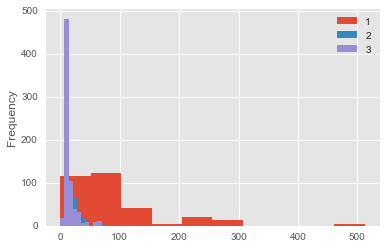

In [679]:
pd.concat(combine).groupby(['Pclass'])['Fare'].plot.hist()
plt.legend()

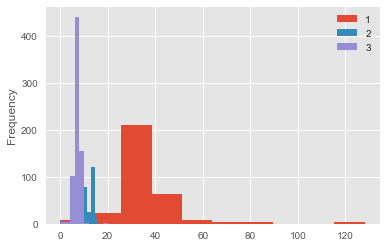

In [680]:
pd.concat(combine).groupby(['Pclass'])['FarePerPass'].plot.hist()
plt.legend()

## Data Cleaning

### Check uniqueness of PassengerId

In [681]:
if pd.concat(combine).PassengerId.nunique() == pd.concat(combine).shape[0]:
    print('PassengerId is unique.') 
else:
    print('PassengerId is not unique.')

PassengerId is unique.


### Fare=0

A group of male passengers who embarked at Southampton - and all but one of whom did not survive - have Fare=0.

Many of these, were part of the 'Gaurantee Group' - the Belfast team sent by shipbuilders Harland & Wolff to accompany the Titanic on her maiden voyage.
https://www.encyclopedia-titanica.org/titanic-guarantee-group/

In [682]:
pd.concat(combine).pipe(lambda x:x[x.Fare==0])

,Age,Cabin,Embarked,Fare,FarePerPass,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,n_pass_per_ticket
179,36.0,NaN,S,0.0,0.0,"Leonard, Mr. Lionel",0,180,3,male,0,0.0,LINE,4
263,40.0,B94,S,0.0,0.0,"Harrison, Mr. William",0,264,1,male,0,0.0,112059,1
271,25.0,NaN,S,0.0,0.0,"Tornquist, Mr. William Henry",0,272,3,male,0,1.0,LINE,4
277,NaN,NaN,S,0.0,0.0,"Parkes, Mr. Francis ""Frank""",0,278,2,male,0,0.0,239853,3
302,19.0,NaN,S,0.0,0.0,"Johnson, Mr. William Cahoone Jr",0,303,3,male,0,0.0,LINE,4
413,NaN,NaN,S,0.0,0.0,"Cunningham, Mr. Alfred Fleming",0,414,2,male,0,0.0,239853,3
466,NaN,NaN,S,0.0,0.0,"Campbell, Mr. William",0,467,2,male,0,0.0,239853,3
481,NaN,NaN,S,0.0,0.0,"Frost, Mr. Anthony Wood ""Archie""",0,482,2,male,0,0.0,239854,1
597,49.0,NaN,S,0.0,0.0,"Johnson, Mr. Alfred",0,598,3,male,0,0.0,LINE,4
633,NaN,NaN,S,0.0,0.0,"Parr, Mr. William Henry Marsh",0,634,1,male,0,0.0,112052,1


### Fix nulls

In [683]:
for df in combine:
    print(df.isnull().apply(pd.Series.value_counts).fillna(0))

       PassengerId  Survived  Pclass   Name    Sex  Age  SibSp  Parch  Ticket  \
False        891.0     891.0   891.0  891.0  891.0  714  891.0  891.0   891.0   
True           0.0       0.0     0.0    0.0    0.0  177    0.0    0.0     0.0   

        Fare  Cabin  Embarked  n_pass_per_ticket  FarePerPass  
False  891.0    204       889              891.0        891.0  
True     0.0    687         2                0.0          0.0  
       PassengerId  Pclass   Name    Sex  Age  SibSp  Parch  Ticket  Fare  \
False        418.0   418.0  418.0  418.0  332  418.0  418.0   418.0   417   
True           0.0     0.0    0.0    0.0   86    0.0    0.0     0.0     1   

       Cabin  Embarked  n_pass_per_ticket  FarePerPass  
False     91     418.0              418.0          417  
True     327       0.0                0.0            1  


We find nulls in Age, Cabin, Fare (test data only) and Embarked. For Age, Fare and Embarked we will replace nulls with imputed values. For Cabin, because there are so many missing values, we will not fix nulls.

#### Age
Impute age using median age of Sex, Pclass and Title category.

Get titles by extracting elements of Name that end with a period.

In [684]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

Check that all entries have a title

In [685]:
pd.concat(combine).Title.isnull().value_counts()

False    1309
Name: Title, dtype: int64

In [686]:
pd.concat(combine).Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [687]:
combine[0].groupby(['Pclass','Title'])['Age'].agg(['size', 'median'])

size  median
Pclass Title                 
1      Capt         1    70.0
       Col          2    58.0
       Countess     1    33.0
       Don          1    40.0
       Dr           5    46.5
       Jonkheer     1    38.0
       Lady         1    48.0
       Major        2    48.5
       Master       3     4.0
       Miss        46    30.0
       Mlle         2    24.0
       Mme          1    24.0
       Mr         107    40.0
       Mrs         42    41.5
       Sir          1    49.0
2      Dr           2    38.5
       Master       9     1.0
       Miss        34    24.0
       Mr          91    31.0
       Mrs         41    32.0
       Ms           1    28.0
       Rev          6    46.5
3      Master      28     4.0
       Miss       102    18.0
       Mr         319    26.0
       Mrs         42    31.0

Notice that the Masters are very young, and the young women (Mlle/Ms/Miss) are young and numerous. We will use this information in imputing ages.

In [688]:
# Replace titles with 'title categories'
title_categories = {'older':['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 
          'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'Mrs', 'Mme',
          'Mr'],
 'young_male':['Master'],
 'young_female':['Mlle', 'Ms', 'Miss']}

for dataset in combine:
    for title_category, titles in title_categories.items():
        dataset['Title'] = dataset['Title'].replace(titles, title_category)

In [689]:
combine[0].head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,n_pass_per_ticket,FarePerPass,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,7.25000,older
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,35.64165,older
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,7.92500,young_female
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,26.55000,older
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,8.05000,older
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1,8.45830,older
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,2,25.93125,older
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,5,4.21500,young_male
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,3,3.71110,older
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,2,15.03540,older


In [690]:
median_ages_wtitle = combine[0].groupby(['Sex', 'Pclass', 'Title'], as_index=False)['Age'].median()
median_ages_wtitle

,Sex,Pclass,Title,Age
0,female,1,older,41.5
1,female,1,young_female,30.0
2,female,2,older,32.0
3,female,2,young_female,24.0
4,female,3,older,31.0
5,female,3,young_female,18.0
6,male,1,older,42.0
7,male,1,young_male,4.0
8,male,2,older,31.0
9,male,2,young_male,1.0


In [691]:
for index, dataset in enumerate(combine):
    combine[index] = dataset.merge(median_ages_wtitle, on=['Sex', 'Pclass', 'Title'], suffixes=['', '_imputed'])
    combine[index]['Age'] = combine[index]['Age'].fillna(combine[index]['Age_imputed'])
    combine[index] = combine[index].drop('Age_imputed', axis=1)

In [692]:
# median_ages = combine[0].groupby(['Sex', 'Pclass'], as_index=False)['Age'].median()
# median_ages

In [693]:
# for index, dataset in enumerate(combine):
#     combine[index] = dataset.merge(median_ages, on=['Sex', 'Pclass'], suffixes=['', '_imputed'])
#     combine[index]['Age'] = combine[index]['Age'].fillna(combine[index]['Age_imputed'])
#     combine[index] = combine[index].drop('Age_imputed', axis=1)

In [694]:
combine[1].isnull().apply(pd.Series.value_counts).fillna(0)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,n_pass_per_ticket,FarePerPass,Title
False,418.0,418.0,418.0,418.0,418.0,418.0,418.0,418.0,417,91,418.0,418.0,417,418.0
True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,327,0.0,0.0,1,0.0


#### Fare & Fare per Passenger

Impute fare using median fare of Sex and Pclass 

In [695]:
median_fares = combine[0].groupby(['Sex', 'Pclass'], as_index=False)['Fare'].median()
median_fares

,Sex,Pclass,Fare
0,female,1,82.66455
1,female,2,22.00000
2,female,3,12.47500
3,male,1,41.26250
4,male,2,13.00000
5,male,3,7.92500


In [696]:
for index, dataset in enumerate(combine):
    combine[index] = dataset.merge(median_fares, on=['Sex', 'Pclass'], suffixes=['', '_imputed'])
    combine[index]['Fare'] = combine[index]['Fare'].fillna(combine[index]['Fare_imputed'])
    combine[index] = combine[index].drop('Fare_imputed', axis=1)

In [697]:
combine[0].pipe(lambda x:x[x.Fare.isnull()])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,n_pass_per_ticket,FarePerPass,Title


In [698]:
median_fares_per_pass = combine[0].groupby(['Sex', 'Pclass'], as_index=False)['FarePerPass'].median()
median_fares_per_pass

,Sex,Pclass,FarePerPass
0,female,1,30.000000
1,female,2,12.350000
2,female,3,7.589600
3,male,1,29.700000
4,male,2,12.334733
5,male,3,7.775000


In [699]:
for index, dataset in enumerate(combine):
    combine[index] = dataset.merge(median_fares_per_pass, on=['Sex', 'Pclass'], suffixes=['', '_imputed'])
    combine[index]['FarePerPass'] = combine[index]['FarePerPass'].fillna(combine[index]['FarePerPass_imputed'])
    combine[index] = combine[index].drop('FarePerPass_imputed', axis=1)

#### Embarked

Embarked feature takes S, Q, C values based on port of embarkation. Our training dataset has two missing values. We simply fill these with the most common occurance. Also convert to dummy variables

In [700]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [701]:
for index, dataset in enumerate(combine):
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port).map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    #combine[index] = pd.get_dummies(dataset, columns=['Embarked'], drop_first=True)

In [702]:
combine[0].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,n_pass_per_ticket,FarePerPass,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,0,1,7.250000,older
1,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,0,1,8.050000,older
2,6,0,3,"Moran, Mr. James",male,26.0,0,0,330877,8.4583,NaN,2,1,8.458300,older
3,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,NaN,0,1,8.050000,older
4,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,0,7,4.467857,older


#### Check nulls

In [703]:
combine[0].isnull().apply(pd.Series.value_counts).fillna(0)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,n_pass_per_ticket,FarePerPass,Title
False,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,204,891.0,891.0,891.0,891.0
True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,687,0.0,0.0,0.0,0.0


In [704]:
combine[1].isnull().apply(pd.Series.value_counts).fillna(0)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,n_pass_per_ticket,FarePerPass,Title
False,418.0,418.0,418.0,418.0,418.0,418.0,418.0,418.0,418.0,91,418.0,418.0,418.0,418.0
True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,327,0.0,0.0,0.0,0.0


## Data Transformation

### Convert Fare and FarePerPass to ordinal

Probability of survival seems to increase with fare.

In [705]:
train_df['FareGroup'] = pd.cut(train_df.Fare, bins=20, precision=1)

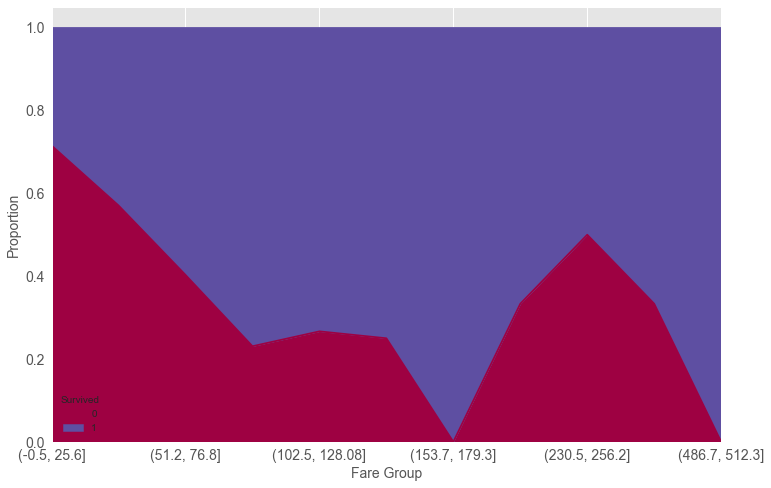

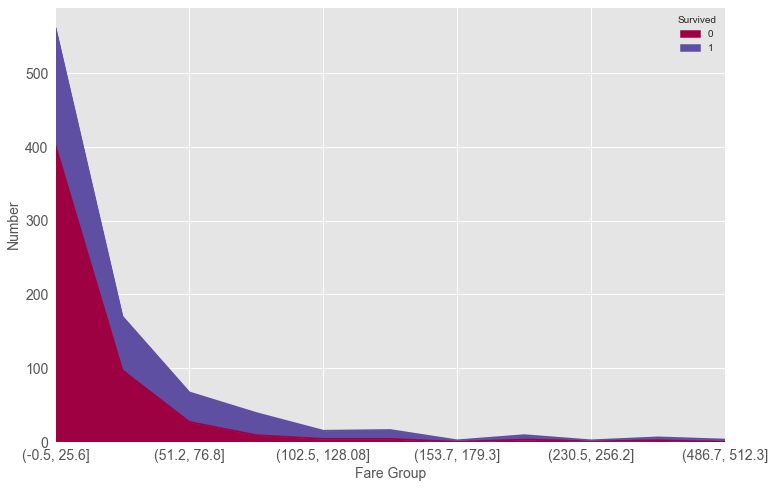

In [706]:
figsize(12,8)
df = (train_df.groupby(['FareGroup', 'Survived'])
 .size()
 .unstack()
 .fillna(0))
df.divide(df.sum(axis=1), axis=0).plot.area(colormap='Spectral', fontsize=figTextSize)
plt.xlabel('Fare Group', fontsize=figTextSize)
plt.ylabel('Proportion', fontsize=figTextSize)
           
df.plot.area(colormap='Spectral', fontsize=figTextSize)
#plt.ylim(0,1)
plt.xlabel('Fare Group', fontsize=figTextSize)
plt.ylabel('Number', fontsize=figTextSize)
#plt.legend(loc='upper left', fontsize=figTextSize-2, frameon=True);

In [707]:
train_df = train_df.drop(['FareGroup'], axis=1)

In [708]:
nbins=4

out, fare_bins = pd.qcut(combine[0].Fare, q=nbins,retbins=True)
fare_bins[0] = 0
fare_bins[-1] = fare_bins[-1]+100

for i, dataset in enumerate(combine):
    combine[i]['Fare'] = pd.cut(dataset.Fare, bins=fare_bins, include_lowest=True, labels=list(range(nbins))).astype(int)

In [709]:
nbins=4

out, fare_bins = pd.qcut(combine[0].FarePerPass, q=nbins,retbins=True)
fare_bins[0] = 0
fare_bins[-1] = fare_bins[-1]+100

for i, dataset in enumerate(combine):
    combine[i]['FarePerPass'] = pd.cut(dataset.FarePerPass, bins=fare_bins, include_lowest=True, labels=list(range(nbins))).astype(int)

In [710]:
combine[0].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,n_pass_per_ticket,FarePerPass,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,0,NaN,0,1,0,older
1,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,1,NaN,0,1,1,older
2,6,0,3,"Moran, Mr. James",male,26.0,0,0,330877,1,NaN,2,1,2,older
3,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,1,NaN,0,1,1,older
4,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,3,NaN,0,7,0,older


### Sex

Convert categorical variable to dummies.

In [711]:
for index, dataset in enumerate(combine):
    combine[index] = pd.get_dummies(dataset, columns=['Sex'], drop_first=True)

In [712]:
combine[0].head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,n_pass_per_ticket,FarePerPass,Title,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,0,NaN,0,1,0,older,1
1,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,1,NaN,0,1,1,older,1
2,6,0,3,"Moran, Mr. James",26.0,0,0,330877,1,NaN,2,1,2,older,1
3,13,0,3,"Saundercock, Mr. William Henry",20.0,0,0,A/5. 2151,1,NaN,0,1,1,older,1
4,14,0,3,"Andersson, Mr. Anders Johan",39.0,1,5,347082,3,NaN,0,7,0,older,1


In [713]:
# for index, dataset in enumerate(combine):
#     combine[index] = dataset.drop(['Sex_male'], axis=1)

### Age to ordinal

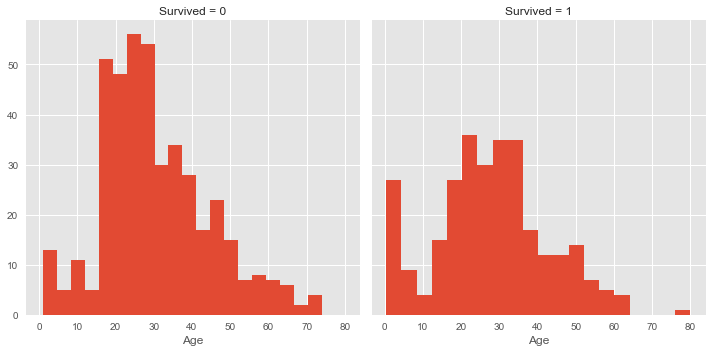

In [714]:
figsize(14,12)

g = sns.FacetGrid(train_df, col='Survived', size=5)
g.map(plt.hist, 'Age', bins=20)

In [715]:
train_df['AgeGroup'] = pd.cut(train_df.Age, bins=40, precision=1)

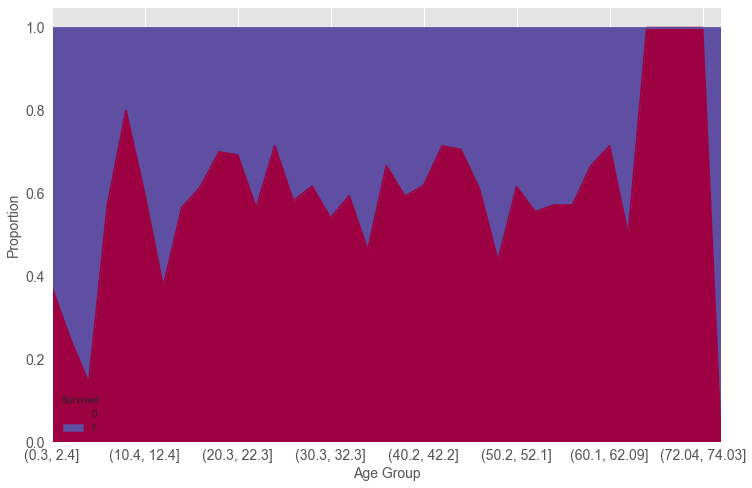

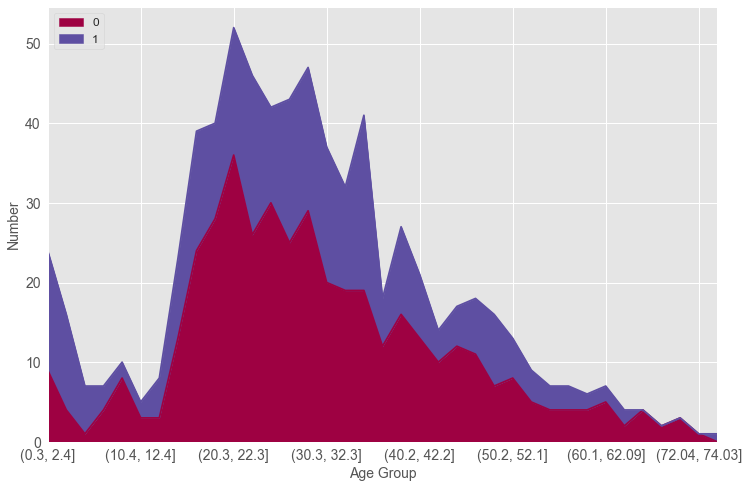

In [716]:
figsize(12,8)
df = (train_df.groupby(['AgeGroup', 'Survived'])
 .size()
 .unstack()
 .fillna(0))
df.divide(df.sum(axis=1), axis=0).plot.area(colormap='Spectral', fontsize=figTextSize)
plt.xlabel('Age Group', fontsize=figTextSize)
plt.ylabel('Proportion', fontsize=figTextSize)
           
df.plot.area(colormap='Spectral', fontsize=figTextSize)
#plt.ylim(0,1)
plt.xlabel('Age Group', fontsize=figTextSize)
plt.ylabel('Number', fontsize=figTextSize)
plt.legend(loc='upper left', fontsize=figTextSize-2, frameon=True);

In [717]:
train_df = train_df.drop('AgeGroup', axis=1)

In [718]:
combine[0].Age.head()

0    22.0
1    35.0
2    26.0
3    20.0
4    39.0
Name: Age, dtype: float64

In [719]:
nbins=5

out, age_bins = pd.cut(combine[0].Age, bins=nbins,retbins=True)
age_bins[0] = 0
age_bins[-1] = 100

for i, dataset in enumerate(combine):
    combine[i]['Age'] = pd.cut(dataset.Age, bins=age_bins, labels=list(range(nbins))).astype(int)

In [720]:
combine[0].head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,n_pass_per_ticket,FarePerPass,Title,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,0,NaN,0,1,0,older,1
1,5,0,3,"Allen, Mr. William Henry",2,0,0,373450,1,NaN,0,1,1,older,1
2,6,0,3,"Moran, Mr. James",1,0,0,330877,1,NaN,2,1,2,older,1
3,13,0,3,"Saundercock, Mr. William Henry",1,0,0,A/5. 2151,1,NaN,0,1,1,older,1
4,14,0,3,"Andersson, Mr. Anders Johan",2,1,5,347082,3,NaN,0,7,0,older,1


## Feature Extraction

### Family ID

In [735]:
for i, dataset in enumerate(combine):
    combine[i]['FamSize'] = dataset['SibSp'] + dataset['Parch'] + 1
    combine[i]['Surname'] = dataset.Name.str.extract('([A-Za-z]+),', expand=False)
    combine[i]['FamilyId'] = dataset.FamSize.astype(str) + dataset.Surname
    combine[i].loc[combine[i]['FamSize']==1, 'FamilyId'] = 'NoFam'

In [736]:
combine[0].head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,n_pass_per_ticket,FarePerPass,Title,Sex_male,Surname,FamSize,FamilyId
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,0,NaN,0,1,0,older,1,Braund,2,2Braund
1,5,0,3,"Allen, Mr. William Henry",2,0,0,373450,1,NaN,0,1,1,older,1,Allen,1,NoFam
2,6,0,3,"Moran, Mr. James",1,0,0,330877,1,NaN,2,1,2,older,1,Moran,1,NoFam
3,13,0,3,"Saundercock, Mr. William Henry",1,0,0,A/5. 2151,1,NaN,0,1,1,older,1,Saundercock,1,NoFam
4,14,0,3,"Andersson, Mr. Anders Johan",2,1,5,347082,3,NaN,0,7,0,older,1,Andersson,7,7Andersson


Most passengers with the same Ticket have the same Surname, but not all.

In [738]:
pd.concat(combine).groupby('Ticket')['Surname'].nunique().value_counts()

1    862
2     48
3     14
4      3
7      1
5      1
Name: Surname, dtype: int64

### Interaction of Pclass and Age

In [629]:
mean_age = combine[0]['Age'].mean()
mean_pclass = combine[0]['Pclass'].mean()

for i, dataset in enumerate(combine):
    #dataset['Age*Class'] = (dataset.Age-mean_age) * (dataset.Pclass-mean_pclass)\
    dataset['Age*Class'] = (dataset.Age) * (dataset.Pclass)
    combine[i] = dataset

combine[0].loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,6,2,3
2,3,1,3
3,3,1,3
4,6,2,3
5,3,1,3
6,3,1,3
7,3,1,3
8,3,1,3
9,3,1,3


### Titles

In [630]:
train_df.Name.unique()

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

Get titles by extracting elements of name that end with a period

In [631]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(combine[0]['Title'], combine[0]['Survived'])

Survived,0,1
Title,,
Capt,1,0
Col,1,1
Countess,0,1
Don,1,0
Dr,4,3
Jonkheer,1,0
Lady,0,1
Major,1,1
Master,17,23


We can replace many titles with a more common name or classify them as `Rare`.

In [632]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace(['Mlle', 'Ms', 'Mme'], 'Miss')
    
    
combine[0].groupby(['Title'], as_index=False)['Survived'].mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.704301
2,Mr,0.156673
3,Mrs,0.792000
4,Rare,0.347826


In [633]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

In [634]:
## Convert the categorical titles to dummies.
# for index, dataset in enumerate(combine):
#     combine[index]['Title'] = np.where(combine[index]['Title']=='Rare', 'Rare', 'Common')
#     combine[index] = pd.get_dummies(dataset, columns=['Title'], drop_first=True)

### Travelling without family

In [636]:
for index, dataset in enumerate(combine):
    dataset['noFamily'] = (dataset['SibSp'] + dataset['Parch'])==0
    combine[index] = pd.get_dummies(dataset, columns=['noFamily'], drop_first=True)

In [637]:
combine[0].head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,n_pass_per_ticket,FarePerPass,Title,Sex_male,Age*Class,noFamily_True
0,1,0,3,1,1,0,A/5 21171,0,NaN,0,1,0,1,1,3,0
1,5,0,3,2,0,0,373450,1,NaN,0,1,1,1,1,6,1
2,6,0,3,1,0,0,330877,1,NaN,2,1,2,1,1,3,1
3,13,0,3,1,0,0,A/5. 2151,1,NaN,0,1,1,1,1,3,1
4,14,0,3,2,1,5,347082,3,NaN,0,7,0,1,1,6,0


### No cabin

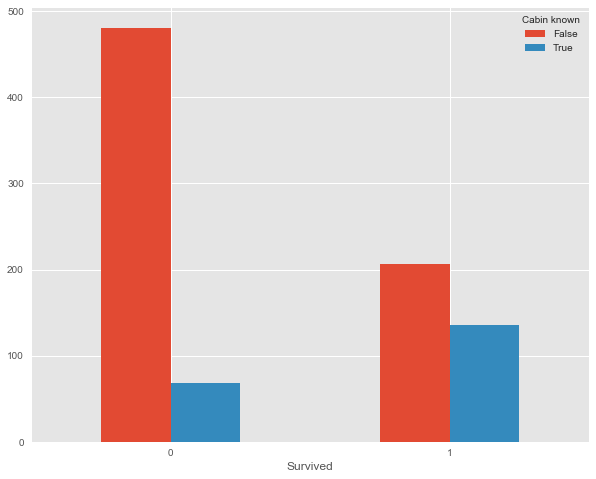

In [638]:
figsize(10,8)
train_df.groupby('Survived')['Cabin'].apply(lambda x: x.notnull().value_counts()).unstack().plot.bar()
plt.xticks(rotation=0)
plt.legend(title='Cabin known')

Add it as a dummy variable

In [639]:
for index, dataset in enumerate(combine):
    dataset['CabinKnown'] = dataset['Cabin'].notnull()
    combine[index] = pd.get_dummies(dataset, columns=['CabinKnown'], drop_first=True)

In [640]:
combine[0].head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,n_pass_per_ticket,FarePerPass,Title,Sex_male,Age*Class,noFamily_True,CabinKnown_True
0,1,0,3,1,1,0,A/5 21171,0,NaN,0,1,0,1,1,3,0,0
1,5,0,3,2,0,0,373450,1,NaN,0,1,1,1,1,6,1,0
2,6,0,3,1,0,0,330877,1,NaN,2,1,2,1,1,3,1,0
3,13,0,3,1,0,0,A/5. 2151,1,NaN,0,1,1,1,1,3,1,0
4,14,0,3,2,1,5,347082,3,NaN,0,7,0,1,1,6,0,0


### Number of cabins

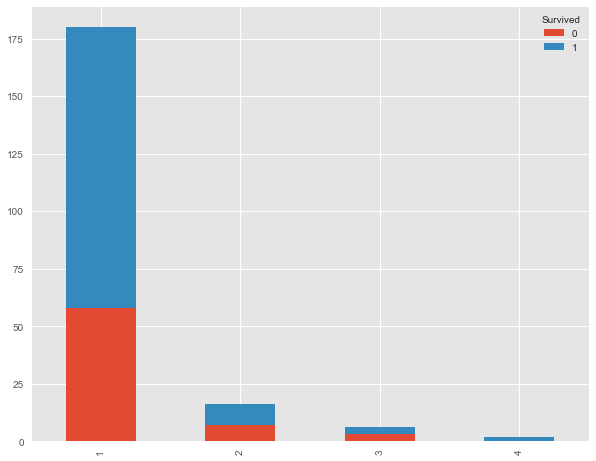

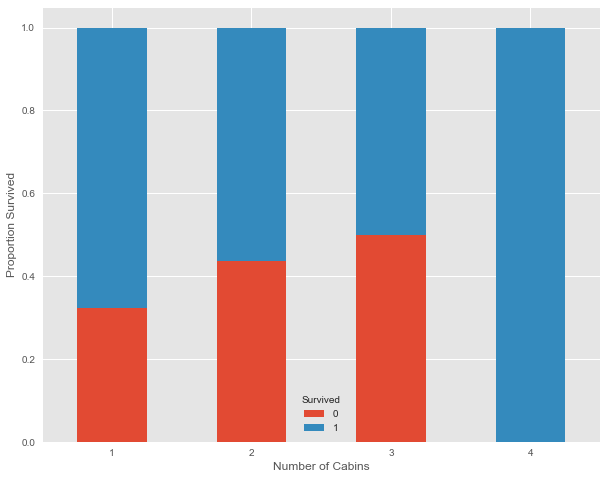

In [641]:
train_df.pipe(lambda x:x[x.Cabin.notnull()]).groupby('Survived')['Cabin'].apply(lambda x:(x.str.count(' ')+1).value_counts()).unstack().fillna(0).T.plot.bar(stacked=True)
train_df.pipe(lambda x:x[x.Cabin.notnull()]).groupby('Survived')['Cabin'].apply(lambda x:(x.str.count(' ')+1).value_counts()).unstack().fillna(0).T.apply(lambda x:x/x.sum(), axis=1).plot.bar(stacked=True)
plt.xticks(rotation=0)
plt.xlabel('Number of Cabins')
plt.ylabel('Proportion Survived')

In [642]:
combine[0].pipe(lambda x:x[x.PassengerId.isin([74, 112, 123, 124])])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,n_pass_per_ticket,FarePerPass,Title,Sex_male,Age*Class,noFamily_True,CabinKnown_True
18,74,0,3,1,1,0,2680,1,NaN,1,2,0,1,1,3,0,0
459,112,0,3,0,1,0,2665,1,NaN,1,2,0,2,0,0,0,0
752,124,1,2,2,0,0,27267,1,E101,0,1,2,2,0,4,1,1
792,123,0,2,2,1,0,237736,2,NaN,1,2,3,1,1,4,0,0


In [643]:
for index, dataset in enumerate(combine):
    combine[index]['nCabins'] = dataset['Cabin'].str.count(' ').fillna(0)+1

Now drop cabin

In [644]:
for index, dataset in enumerate(combine):
    combine[index] = dataset.drop(['Cabin'], axis=1)

In [645]:
combine[0].head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked,n_pass_per_ticket,FarePerPass,Title,Sex_male,Age*Class,noFamily_True,CabinKnown_True,nCabins
0,1,0,3,1,1,0,A/5 21171,0,0,1,0,1,1,3,0,0,1.0
1,5,0,3,2,0,0,373450,1,0,1,1,1,1,6,1,0,1.0
2,6,0,3,1,0,0,330877,1,2,1,2,1,1,3,1,0,1.0
3,13,0,3,1,0,0,A/5. 2151,1,0,1,1,1,1,3,1,0,1.0
4,14,0,3,2,1,5,347082,3,0,7,0,1,1,6,0,0,1.0


## Feature Selection

For now just use this hard-coded selection of features

In [646]:
#cols = ['Pclass','Sex_male', 'Age', 'FarePerPass', 'Embarked', 'Title', 'noFamily_True', 'Age*Class']
#cols = ['Sex_male', 'Age', 'FarePerPass', 'Embarked', 'Title', 'noFamily_True', 'Age*Class']
cols = ['Pclass','Sex_male', 'Age', 'Embarked', 'Title', 'SibSp', 'Parch', 'noFamily_True', 'Age*Class']

The remainder of this section can be ignored.

### Pclass

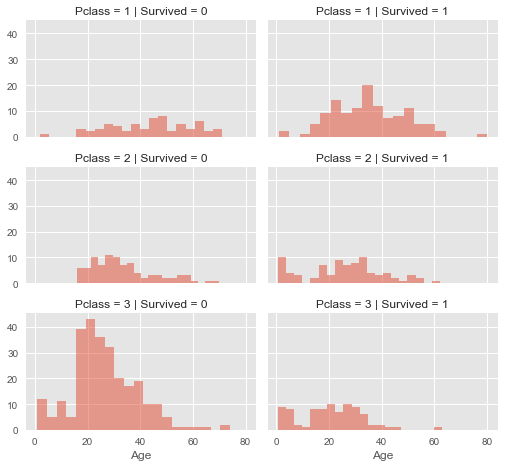

In [647]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

In [648]:
# for index, dataset in enumerate(combine):
#     combine[index] = pd.get_dummies(dataset, columns=['Pclass'], drop_first=True)

In [649]:
combine[0].head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked,n_pass_per_ticket,FarePerPass,Title,Sex_male,Age*Class,noFamily_True,CabinKnown_True,nCabins
0,1,0,3,1,1,0,A/5 21171,0,0,1,0,1,1,3,0,0,1.0
1,5,0,3,2,0,0,373450,1,0,1,1,1,1,6,1,0,1.0
2,6,0,3,1,0,0,330877,1,2,1,2,1,1,3,1,0,1.0
3,13,0,3,1,0,0,A/5. 2151,1,0,1,1,1,1,3,1,0,1.0
4,14,0,3,2,1,5,347082,3,0,7,0,1,1,6,0,0,1.0


### Ticket

In [650]:
pd.concat(combine).Ticket.str.extract('([a-zA-z]+)', expand=False).value_counts(dropna=False)

NaN      957
PC        92
C         55
A         40
SOTON     27
SC        25
CA        22
STON      22
S         21
W         17
F         12
LINE       4
PP         4
P          2
AQ         2
WE         2
LP         1
Fa         1
SCO        1
SW         1
SO         1
Name: Ticket, dtype: int64

### PassengerId
PassengerId seems to have no relationship with survival

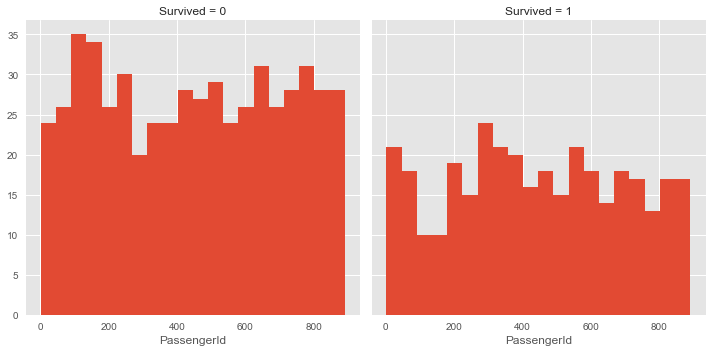

In [651]:
figsize(14,12)

g = sns.FacetGrid(combine[0], col='Survived', size=5)
g.map(plt.hist, 'PassengerId', bins=20)

# Model

## Select data

In [652]:
X_train = combine[0].copy().loc[:,cols]
Y_train = combine[0]["Survived"]

X_test  = combine[1].copy().loc[:,cols]
labels_test = combine[1].copy()['PassengerId']

X_train.shape, Y_train.shape, X_test.shape

((891, 9), (891,), (418, 9))

In [653]:
X_train.head()

,Pclass,Sex_male,Age,Embarked,Title,SibSp,Parch,noFamily_True,Age*Class
0,3,1,1,0,1,1,0,0,3
1,3,1,2,0,1,0,0,1,6
2,3,1,1,2,1,0,0,1,3
3,3,1,1,0,1,0,0,1,3
4,3,1,2,0,1,1,5,0,6


In [654]:
cols

['Pclass',
 'Sex_male',
 'Age',
 'Embarked',
 'Title',
 'SibSp',
 'Parch',
 'noFamily_True',
 'Age*Class']

In [655]:
df = combine[0].copy().loc[:,['Survived', 'PassengerId']+cols]
df = df.rename(columns={'Sex_male':'Sex','noFamily_True':'IsAlone'})
df.to_csv('train_new.csv', index=False)

## Check feature correlation

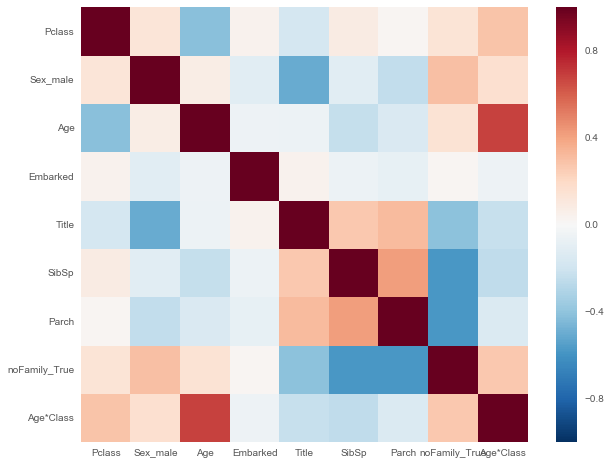

In [656]:
figsize(10,8)
sns.heatmap(X_train.corr())

## Fit models

Generate cross-validated (LOO) scores for a list of classifiers.

In [657]:
def cv_score(X, y, clf, cv):
    cv_score = cross_val_score(clf, X, y, cv=cv).mean()
    return cv_score
# 'Random Forest':'RandomForestClassifier(n_estimators=500)',
clfs = {'Support Vector Machines':'SVC()',
        'KNN':'KNeighborsClassifier(n_neighbors = 3)',
        'Logistic Regression':'LogisticRegression()', 
        'Naive Bayes':'GaussianNB()',
        'Perceptron':'Perceptron()', 
        'Stochastic Gradient Decent':'SGDClassifier()',
        'Linear SVC':'LinearSVC()',
        'Decision Tree':'DecisionTreeClassifier()',
        'XGBoost':'XGBClassifier()'} 

In [658]:
models = {}
cv=LeaveOneOut()

for clf_name, clf in clfs.items():
    print(clf_name)
    models[clf_name] = cv_score(X_train, Y_train, eval(clf), cv)

Support Vector Machines
KNN
Logistic Regression
Naive Bayes
Perceptron


/Users/simondunne/anaconda/envs/babbel-data/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Stochastic Gradient Decent


/Users/simondunne/anaconda/envs/babbel-data/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Linear SVC
Decision Tree
XGBoost


In [659]:
models = pd.DataFrame.from_dict(models, orient='index')
models.reset_index(inplace=True)
models.columns = ['Model', 'Score']
models.sort_values(by='Score', ascending=False)

,Model,Score
8,XGBoost,0.831650
0,Support Vector Machines,0.826038
2,Logistic Regression,0.821549
6,Linear SVC,0.813692
3,Naive Bayes,0.805836
7,Decision Tree,0.805836
1,KNN,0.802469
4,Perceptron,0.719416
5,Stochastic Gradient Decent,0.710438


## Generate Predictions

In [660]:
# top_clfs = {'Logistic Regression':'LogisticRegression()', 
#         'Decision Tree':'DecisionTreeClassifier()',
#         'XGBoost':'XGBClassifier()'}
top_clfs = {'XGBoost':'XGBClassifier()'}

preds = {}
for clf_name, clf in top_clfs.items():
    clf = eval(clf)
    clf.fit(X_train, Y_train)
    preds[clf_name] = clf.predict(X_test).tolist()

In [661]:
preds = np.round(pd.DataFrame(preds).sum(axis=1)/len(top_clfs)).astype(int).tolist()

In [662]:
submission = pd.DataFrame({
        "PassengerId": labels_test,
        "Survived": preds
    })
submission.to_csv('output/svc_submission_xgb_nofare_sibsp_parch.csv', index=False)

# Rough Work

In [ ]:
## Learning curve
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
logreg_model = LogisticRegression()

def Learning_curve_model(X, Y, model, cv, train_sizes):

    plt.figure()
    plt.title("Learning curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")


    train_sizes, train_scores, test_scores = learning_curve(model, X, Y, cv=cv, n_jobs=4, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
                     
    plt.legend(loc="best")
    plt.grid()
    print(test_scores_mean)
    return plt

#learn curve
if plot_lc==1:
    train_size=np.linspace(.1, 1.0, 15)
    Learning_curve_model(X_train,Y_train, logreg_model, cv, train_size)